## Create and test ion channel model

In [1]:
from channels.cm_ina_original import (protocols,
                                      observations,
                                      simulations,
                                      times,
                                      summary_statistics)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
from functools import wraps

def simulate_model(**pars):
    """Wrapper function around simulations."""
    data = []
    for sim, time in zip(simulations, times):
        for p, v in pars.items():
            try:
                sim.set_constant(p, v)
            except:
                raise RuntimeWarning('Could not set value of {}'.format(p))
                return None
        sim.reset()
        try:
            data.append(sim.run(time, log=['environment.time','membrane.V','ina.i_Na','ina.g','ina.m','ina.h','ina.j']))
        except:
            # Failed simulation
            del(data)
            return None
    return data

def log_transform(f):
    @wraps(f)
    def log_transformed(**log_kwargs):
        kwargs = dict([(key[4:], 10**value) if key.startswith("log")
                       else (key, value)
                       for key, value in log_kwargs.items()])
        return f(**kwargs)
    return log_transformed

def log_model(x):
    return log_transform(simulate_model)(**x)

In [3]:
test = simulate_model()

In [4]:
data = test[0]
d = data.split_periodic(10000, adjust=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['figure.figsize'] = [5, 8]
matplotlib.rcParams['figure.dpi']=80

fig,axes = plt.subplots(nrows=5,ncols=1,sharex=True)

num_plots = len(d)
axes[0].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 0.9, num_plots))))
axes[1].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 0.9, num_plots))))
axes[2].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 0.9, num_plots))))
axes[3].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 0.9, num_plots))))
axes[4].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 0.9, num_plots))))

for d_ in d:
    dpl = d_.trim(9850, 9990)
    axes[0].plot(dpl['environment.time'], dpl['membrane.V'])
    axes[1].plot(dpl['environment.time'], dpl['ina.i_Na'])
    axes[2].plot(dpl['environment.time'], dpl.npview()['ina.m']**3)
    axes[3].plot(dpl['environment.time'], dpl.npview()['ina.h'])
    axes[4].plot(dpl['environment.time'], dpl.npview()['ina.j'])

    
axes[4].set_xlabel('time (ms)')
axes[0].set_ylabel('voltage (mV)')
axes[1].set_ylabel('current (pA/pF)')
axes[2].set_ylabel('m_inf**3')
axes[3].set_ylabel('h_inf')
axes[4].set_ylabel('j_inf')

In [5]:
ss = summary_statistics(test)

In [6]:
assert(len(ss)==len(observations))

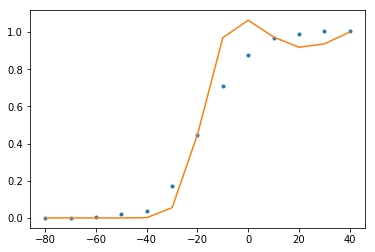

In [7]:
import matplotlib.pyplot as plt
key = observations.exp_id=='0'
plt.plot(observations[key].x, observations[key].y, '.')
plt.plot(observations[key].x, list(ss.values())[0:13])

## Set limits and generate uniform initial priors

In [8]:
from pyabc import Distribution, RV
limits = {#'ina.g_Na': (0,100),
          'ina.a1_m': (0,100),
          'ina.a2_m': (0, 1),
          'ina.a3_m': (0, 1),
          'ina.a4_m': (0, 10),
          'ina.b1_m': (0, 1.),
          'ina.b2_m': (0,100)}
'''
          'ina.c1_h': (0,100),
          'ina.a1_h': (0,1),
          'ina.a2_h': (1,10),
          'ina.a3_h': (0, 100),
          'ina.b1_h': (0,1),
          'ina.b2_h': (0,100),
          'ina.b3_h': (0,100),
          'ina.b4_h': (0,10),
          'ina.b5_h': (0,0.1),
          'ina.b6_h': (1e4, 1e6),
          'ina.b7_h': (0,1)}
'''
'''
            'ina.c1_j': (1,100),
            'ina.a1_j': (124000,130000),
            'ina.a2_j': (0.1,1),
            'ina.a3_j': (1e-5,1e-4),
            'ina.a4_j': (0,0.1),
            'ina.a5_j': (0,100),
            'ina.a6_j': (0,1),
            'ina.a7_j': (0,100),
            'ina.b1_j': (0,1),
            'ina.b2_j': (0,1e-6),
            'ina.b3_j': (0,1),
            'ina.b4_j': (0,100),
            'ina.b5_j': (0,1),
            'ina.b6_j': (0,0.1),
            'ina.b7_j': (0,1),
            'ina.b8_j': (0,100)}
'''
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [9]:
print(prior.rvs())
test = log_model(prior.rvs())

<Parameter 'ina.a1_m': 93.80814086976818, 'ina.a2_m': 0.44067225946762756, 'ina.a3_m': 0.3421828670394518, 'ina.a4_m': 1.233757484483845, 'ina.b1_m': 0.019103246661637208, 'ina.b2_m': 92.93331909100195>


## Run ABC calibration

In [10]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "cm_ina_original_mgate.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/cm_ina_original_mgate.db


In [11]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [12]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


In [13]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=log_model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(5000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.5585327376534017, '1': 1.5585327376534017, '2': 1.5585327376534017, '3': 1.5585327376534017, '4': 1.5585327376534017, '5': 0.5922502978635686, '6': 0.48479560247060055, '7': 0.6880033400331257, '8': 0.9191724622842619, '9': 1.5585327376534017, '10': 1.5585327376534017, '11': 1.5585327376534017, '12': 1.5585327376534017, '13': 1.6660177540432917, '14': 1.6660177540432917, '15': 1.6660177540432917, '16': 1.6660177540432917, '17': 1.6660177540432917, '18': 0.6141022916123275, '19': 0.4000666394868585, '20': 0.46000171656354155, '21': 0.7676278645154099, '22': 1.6660177540432917, '23': 1.6660177540432917, '24': 0.02906218941217941, '25': 0.03367374906920667, '26': 0.03457895737751867, '27': 0.046999392320876986, '28': 0.08141374774960093, '29': 0.10610649611527939, '30': 0.20902979734710037, '31': 0.07785094873262584, '32': 0.2188793689498433, '33': 0.05927794792597441, '34': 0.11670345997926211, '35': 0.16237003127549512, '36': 0.2667507656668848, '3

In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-07-02 09:43:59.126493, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=100, min_acceptance_rate=0.001)

# Results analysis

In [18]:
from pyabc import History

In [19]:
history = History('sqlite:////scratch/cph211/tmp/cm_ina_original_mgate.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2019-07-02 09:43:59.126493, end_time=2019-07-06 00:42:11.051928)>]

In [20]:
history.id = 1

In [21]:
df, w = history.get_distribution(m=0)

In [22]:
df.describe()

name,ina.a1_m,ina.a2_m,ina.a3_m,ina.a4_m,ina.b1_m,ina.b2_m
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,39.182564,0.174226,0.450258,4.976641,0.000664,97.586251
std,0.271514,0.004356,0.036643,2.571784,0.000048,2.678115
min,38.225889,0.158516,0.379348,0.002987,0.000575,84.393725
25%,38.998249,0.170909,0.425470,2.934587,0.000629,97.103917
50%,39.183264,0.173663,0.439097,4.992806,0.000637,98.430168
75%,39.356152,0.177533,0.458045,7.024797,0.000723,99.267865
max,40.391411,0.186807,0.547238,9.990330,0.000790,99.999729


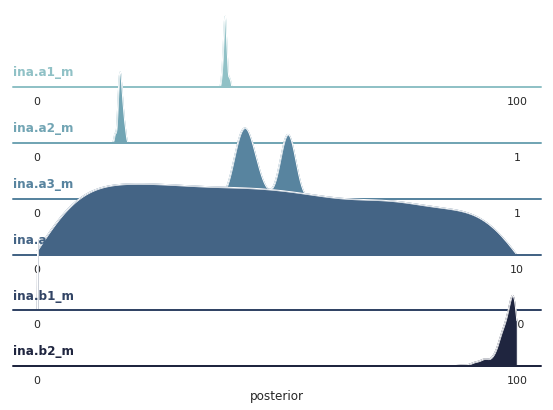

In [23]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=8,height=1.0)

# Samples for quantitative analysis

In [24]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [28]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(log_model(th))
    output = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                           'exp_id': observations.exp_id})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

In [29]:
results = summary_statistics(log_model({}))
original = pd.DataFrame({'x': observations.x, 'y': list(results.values()),
                         'exp_id': observations.exp_id})

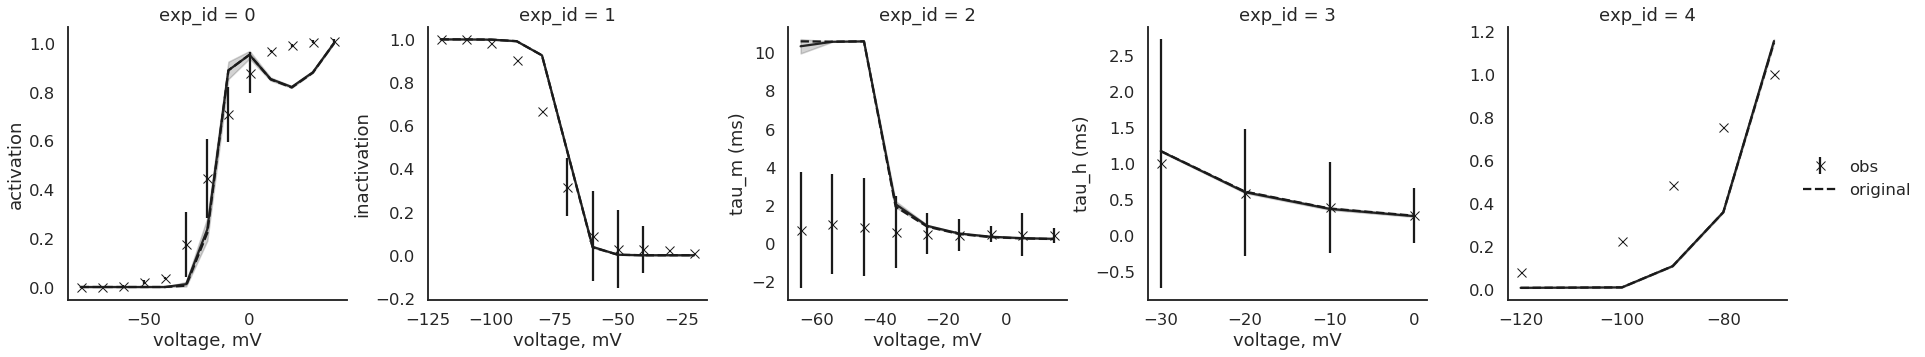

In [30]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')

g = plot_sim_results(samples, obs=observations, original=original)
# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "voltage, mV"]#"time, ms", "time, ms","voltage, mV"]
ylabels = ["activation", "inactivation", "tau_m (ms)", "tau_h (ms)"]#, "normalised current","current density, pA/pF"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [15]:
#g.savefig('/storage/hhecm/cellrotor/chouston/cm_ina_m.pdf',bbox_inches='tight')

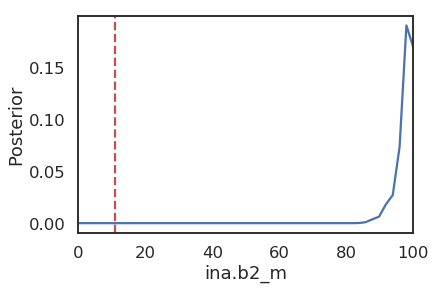

In [37]:
from pyabc.visualization import plot_kde_1d
import matplotlib.pyplot as plt
key='ina.b2_m'
plot_kde_1d(df, w, key, xmin=limits[key][0], xmax=limits[key][1])
plt.axvline(x=11, color='r', linestyle='--')
#plt.savefig('/storage/hhecm/cellrotor/chouston/cm_ina_param_b2m.pdf',bbox_inches='tight')

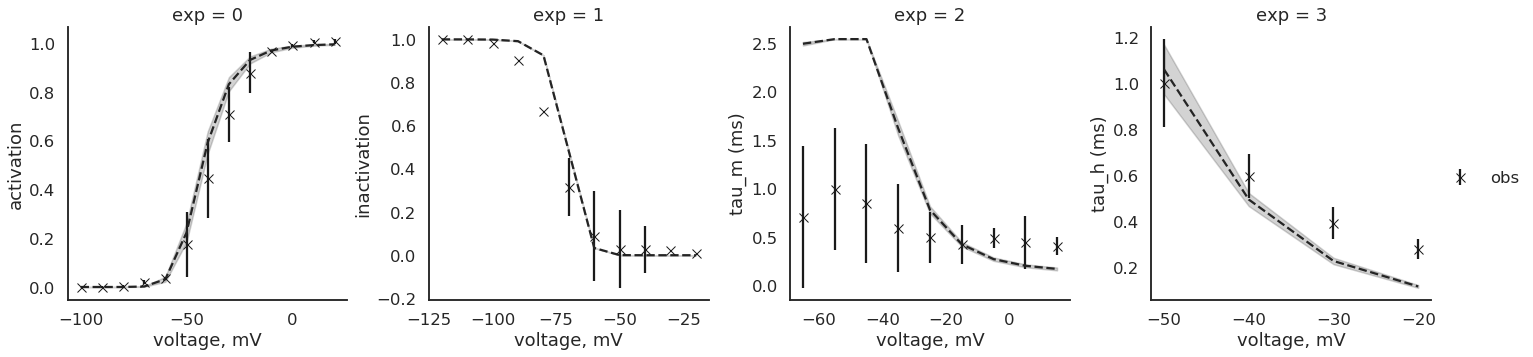

In [26]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=plotting_obs)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "voltage, mV"]#"time, ms", "time, ms","voltage, mV"]
ylabels = ["activation", "inactivation", "tau_m (ms)", "tau_h (ms)"]#, "normalised current","current density, pA/pF"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [27]:
g.savefig('/storage/hhecm/cellrotor/chouston/cm_ina_m_abc.pdf',bbox_inches='tight')

In [31]:
#g.savefig('results/icat-generic/icat_sim_results.pdf')

In [28]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

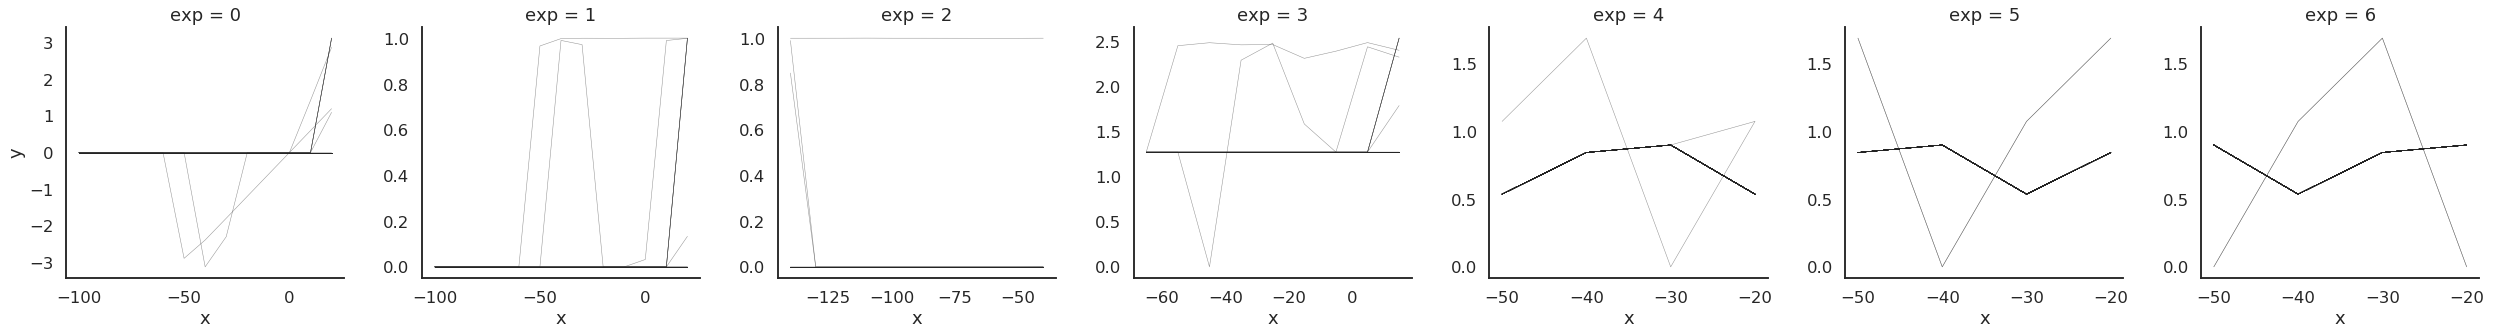

In [29]:
grid2 = plot_sim_results_all(samples)

In [33]:
#grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [35]:
import numpy as np

In [42]:
# Mean current density
print(np.mean(samples[samples.exp=='0'].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp=='0'].groupby('sample').min()['y']))

-0.9792263129382246
0.060452038127623814


In [43]:
import scipy.stats as st
peak_current = samples[samples['exp']=='0'].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [44]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -0.9929750589235674
95% CI: (-1.0714884415582595, -0.8489199437971181)


In [45]:
# Voltage of peak current density
idxs = samples[samples.exp=='0'].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -20.1
STD: 0.7


In [46]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -20.0
95% CI: (-20.0, -20.0)


In [48]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']=='1'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [49]:
print(np.mean(output))
print(np.std(output))

0   -33.399071
1     5.739255
dtype: float64
0    0.823473
1    0.366996
dtype: float64


In [50]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -33.407394098238164
95% CI: (-34.93130871417603, -31.973122716861205)


In [51]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.728938366573993
95% CI: (5.117385157850234, 6.485585591389819)


In [52]:
# Half activation potential
grouped = samples[samples['exp']=='2'].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [53]:
print(np.mean(output))
print(np.std(output))

0   -49.011222
1     4.399126
dtype: float64
0    0.613833
1    0.306758
dtype: float64


In [54]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -49.01404281457659
95% CI: (-50.06478757419054, -47.57952101705519)


In [55]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 4.420440009120772
95% CI: (3.7821747606540193, 4.959106709731536)


In [56]:
# Recovery time constant
grouped = samples[samples.exp=='3'].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [57]:
print(np.mean(output))
print(np.std(output))

114.50830523453935
5.781251582667316


In [58]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 113.75533911706513
95% CI: (104.11137902797657, 125.98102619971708)
